In [1]:
import path_setup
import scipy.io as spio
import mat73
import scipy.io.matlab as spiomat
import numpy as np
import scipy
import matplotlib.pyplot as plt
from blind_localization.models.contrastive_pipeline import *

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)

### Helper Function

In [3]:
def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    try:
        data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
        return _check_keys(data)
    except:
        return mat73.loadmat(filename)

In [4]:
class DotDict(dict):
    # def __getattr__(self, name):
    #     return self[name]
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    def __init__(self, dct):
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DotDict(value)
            self[key] = value
    
    def __repr__(self) -> str:
        return str(list(self.keys()))
    
    def __getstate__(self):
        # Return what you want to pickle
        return self.__dict__

    def __setstate__(self, state):
        # Restore state from the unpickled state
        self.__dict__.update(state)
    

def loadmat_full(filename,structname=None):
    if structname is None:
        mat = loadmat(filename)
    else:
        mat = loadmat(filename)[structname]
    mat = DotDict(mat)
    return mat

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        # if isinstance(dict[key], spiomat.mio5_params.mat_struct):
        if isinstance(dict[key], scipy.io.matlab.mat_struct):
            dict[key] = _todict(dict[key])
        
        elif isinstance(dict[key], np.ndarray):
            
            dict_key_res = np.zeros_like(dict[key])
            # with np.nditer([dict[key],dict_key_res],op_flags=[['readonly'], ['readwrite']]) as it:
            for ind,x in np.ndenumerate(dict_key_res): 
                orig_val = dict[key][ind]
                
                if isinstance(orig_val,scipy.io.matlab.mat_struct):
                    dict_key_res[ind] = _todict(orig_val)
                else:
                    dict_key_res[ind] = orig_val

            dict[key] = dict_key_res
        
    return dict

In [5]:
def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        # if isinstance(elem, spiomat.mio5_params.mat_struct):
        if isinstance(elem, scipy.io.matlab.mat_struct):
            dict[strg] = _todict(elem)
        elif isinstance(elem,np.ndarray) and len(elem) >= 1: # used for the multi maze case; then there might be a cell array of struct that is not correctly unwrapped
            # if isinstance(elem[0], spiomat.mio5_params.mat_struct):
            if isinstance(elem, scipy.io.matlab.mat_struct):
                dict[strg] = np.array([_todict(e) for e in elem],dtype=object)
            else:
                dict[strg]  = elem
        else:
            dict[strg]  = elem
    return dict

### Within Session Spike Features Explored

In [6]:
file_path = "/scratch/th3129/shared/Neuronexus_dataset/AD_HF02_230722_Session4/AD_HF02_230722_Session4.spikes.cellinfo.mat"
source_session = "AD_HF02_4"

In [7]:
mat = loadmat_full(file_path, structname='spikes')
raw_signal, class_labels, swr_timestamp = load_signal_labels(source_session)

100%|██████████| 1024/1024 [00:01<00:00, 531.42it/s]


In [8]:
raw_waveforms = np.vstack(mat['rawWaveform'])

In [9]:
mat

['ids', 'ts', 'times', 'cluID', 'total', 'amplitudes', 'maxWaveformCh', 'maxWaveformCh1', 'phy_maxWaveformCh1', 'phy_amp', 'basename', 'numcells', 'UID', 'sr', 'shankID', 'rawWaveform', 'filtWaveform', 'rawWaveform_all', 'rawWaveform_std', 'filtWaveform_all', 'filtWaveform_std', 'timeWaveform', 'timeWaveform_all', 'peakVoltage', 'channels_all', 'peakVoltage_sorted', 'maxWaveform_all', 'peakVoltage_expFitLengthConstant', 'processinginfo']

In [10]:
source_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", source_session)
public_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", "public")

raw_signal, df, skipped_channels = load_data(source_file["raw_signal_path"], public_file["label_path"], source_file["xml_path"], sheet_name=source_file["sheet_name"],
                                             sample_rate=20000, T=30)
channel_region_map, skipped_channels, channel_channel_map = process_labels(df, public_file["mapping_path"], skipped_channels)
raw_signal = process_signals(raw_signal, channel_channel_map)

100%|██████████| 1024/1024 [00:01<00:00, 530.95it/s]


In [11]:
def visualize_max_waveform_channel(maxWaveformCh, colors, rows=128, cols=8):
    x = np.mod(maxWaveformCh, rows)
    y = maxWaveformCh // rows
    
    fig, ax = plt.subplots()
    ax.scatter(y, x, c=colors)
    plt.show()

In [31]:
color_names = ["red", "orange", "green", "blue", "magenta", "black"]
maxWaveformCh = np.array([channel_channel_map[maxCh] for maxCh in mat['maxWaveformCh']])
# maxWaveformCh =  mat['maxWaveformCh']
class_label_selected = class_labels[maxWaveformCh]
colors = np.array([color_names[c] for c in class_label_selected])

In [32]:
maxWaveformCh

array([  12,   21,   26,   66,  142,  146,  203,  201,  202,  202,  204,
        204,  210,  209,  416,  417,  417,  396,  401,  404,  405,  405,
        406,  408,  411,  413,  414,  470,  524,  527,  528,  532,  536,
        538,  538,  538,  592,  594,  594,  602,  606,  655,  702,  694,
        697,  698,  700,  706,  704,  704,  710,  710,  810,  813,  816,
        817,  830,  933,  935,  938,  943,  947, 1014,   18,   18,   17,
         21,  203,  416,  406,  410,  474,  528,  528,  528,  706,  815,
        816,  933,  203,  205,  706,  814,  815,  818,  203,  202,  380,
        412,  586,  804,  410,  410,  700,  816,  523,  196])

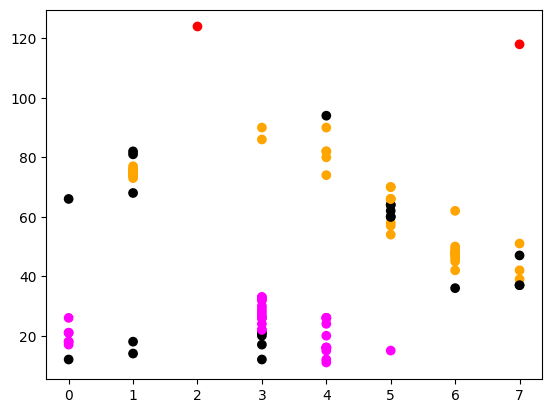

In [33]:
# fix the channel coordinates
visualize_max_waveform_channel(maxWaveformCh, list(colors))

In [34]:
threshold = 100

spike_times = mat['times']
filtered_spike_times = [[spike for spike in neuron_spikes if spike < threshold] for neuron_spikes in spike_times]

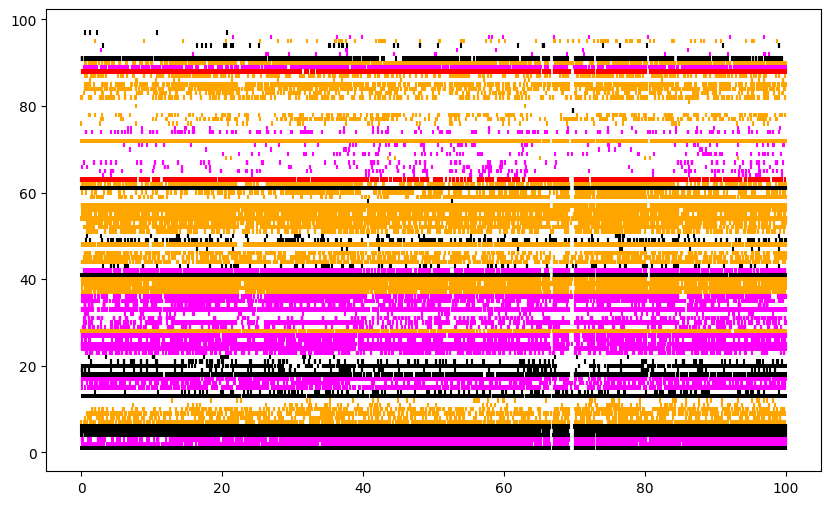

In [35]:
plt.figure(figsize=(10, 6))
for neuron_idx, spikes in enumerate(filtered_spike_times):
    plt.vlines(spikes, neuron_idx + 0.5, neuron_idx + 1.5, colors=colors[neuron_idx])

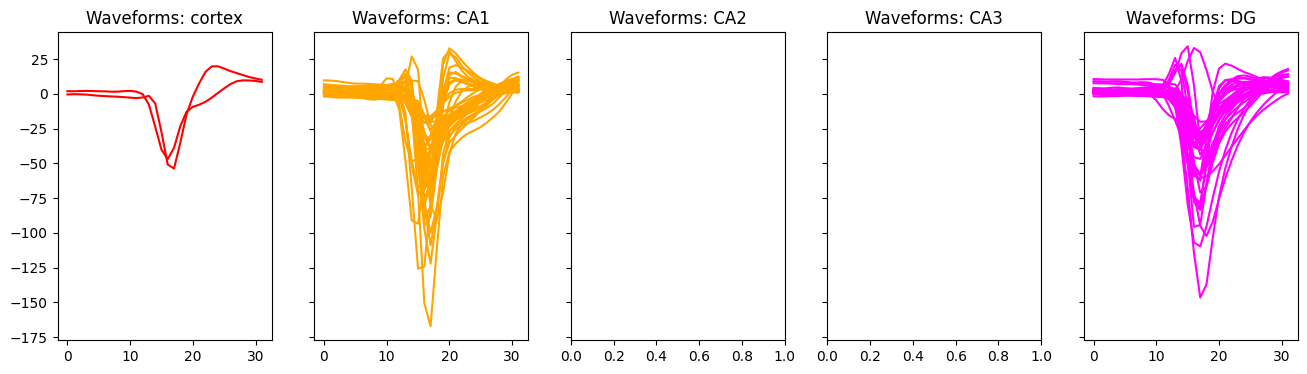

In [36]:
fig, axes = plt.subplots(1, len(color_names)-1, figsize=(16, 4), sharey=True)
brain_regions = ['cortex', 'CA1', 'CA2', 'CA3', 'DG']

for color_idx, color in enumerate(color_names[:-1]):
    for i, (wav, wav_color) in enumerate(zip(raw_waveforms, colors)):
        if wav_color == color:
            axes[color_idx].plot(wav, c=color)
    
    axes[color_idx].set_title(f"Waveforms: {brain_regions[color_idx]}")

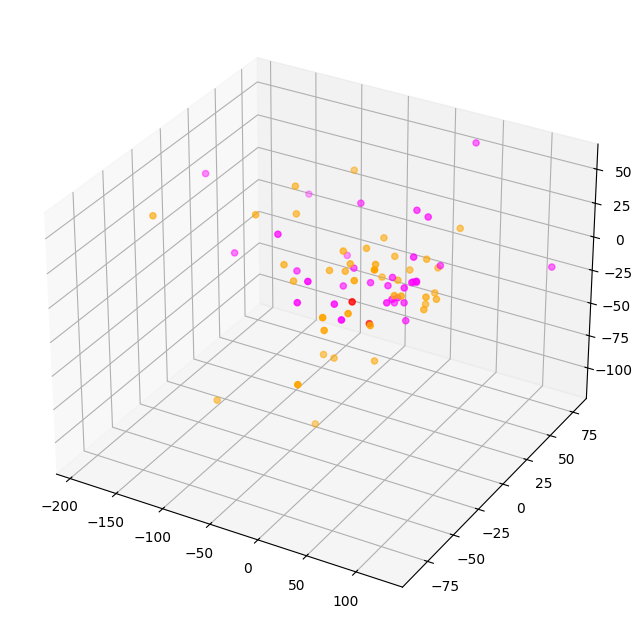

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
coords = pca.fit_transform(raw_waveforms[colors != 'black'])

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA-transformed data
filtered_colors = colors[colors != 'black']
scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=filtered_colors)
plt.show()

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

data = raw_waveforms[colors != 'black']
labels = class_label_selected[colors != 'black']

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

clf = LogisticRegression(C=0.01)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.7666666666666667
Test Accuracy: 0.8666666666666667


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0.5, 1.0, 'Confusion Matrix')

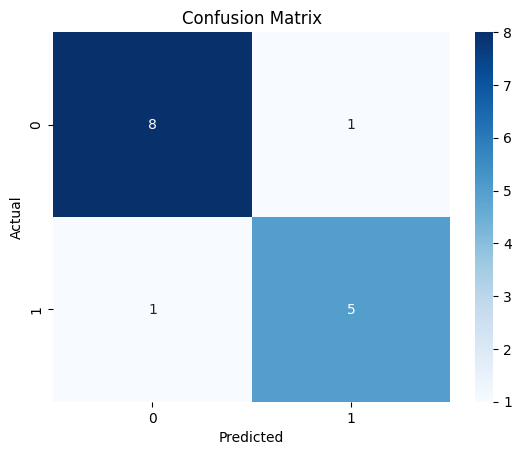

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

### Across Session Raw Waveforms

In [44]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
session_names = ['AD_HF01_1', 'AD_HF02_2', 'AD_HF02_4', 'AD_HF03_1', 'AD_HF03_2', 'NN_syn_01', 'NN_syn_02']
waveforms_all = []
class_labels_all = []  # class_labels of channels with maxWaveform assigned to it
maxWaveformCh_all = []

for i, session in enumerate(sessions):
    file_path = f"/scratch/th3129/shared/Neuronexus_dataset/{session}/{session}.spikes.cellinfo.mat"
    mat = loadmat_full(file_path, structname='spikes')
    raw_signal, class_labels, swr_timestamp = load_signal_labels(session_names[i])

    source_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", session_names[i])
    public_file = load_session_data("script/Neuronexus_preprocessing/file_path_hpc.json", "public")

    raw_signal, df, skipped_channels = load_data(source_file["raw_signal_path"], public_file["label_path"], source_file["xml_path"], sheet_name=source_file["sheet_name"],
                                             sample_rate=20000, T=30)
    channel_region_map, skipped_channels, channel_channel_map = process_labels(df, public_file["mapping_path"], skipped_channels)
    raw_signal = process_signals(raw_signal, channel_channel_map)
    
    raw_waveforms = np.vstack(mat['rawWaveform'])
    maxWaveformCh = np.array([channel_channel_map[maxCh] for maxCh in mat['maxWaveformCh']])
    class_label_selected = class_labels[maxWaveformCh]

    waveforms_all.append(raw_waveforms[class_label_selected != 5])
    class_labels_all.append(class_label_selected[class_label_selected != 5])
    maxWaveformCh_all.append(maxWaveformCh[class_label_selected != 5])

100%|██████████| 1024/1024 [00:01<00:00, 532.11it/s]


In [45]:
colors_all = [[color_names[c] for c in class_labels] for class_labels in class_labels_all]

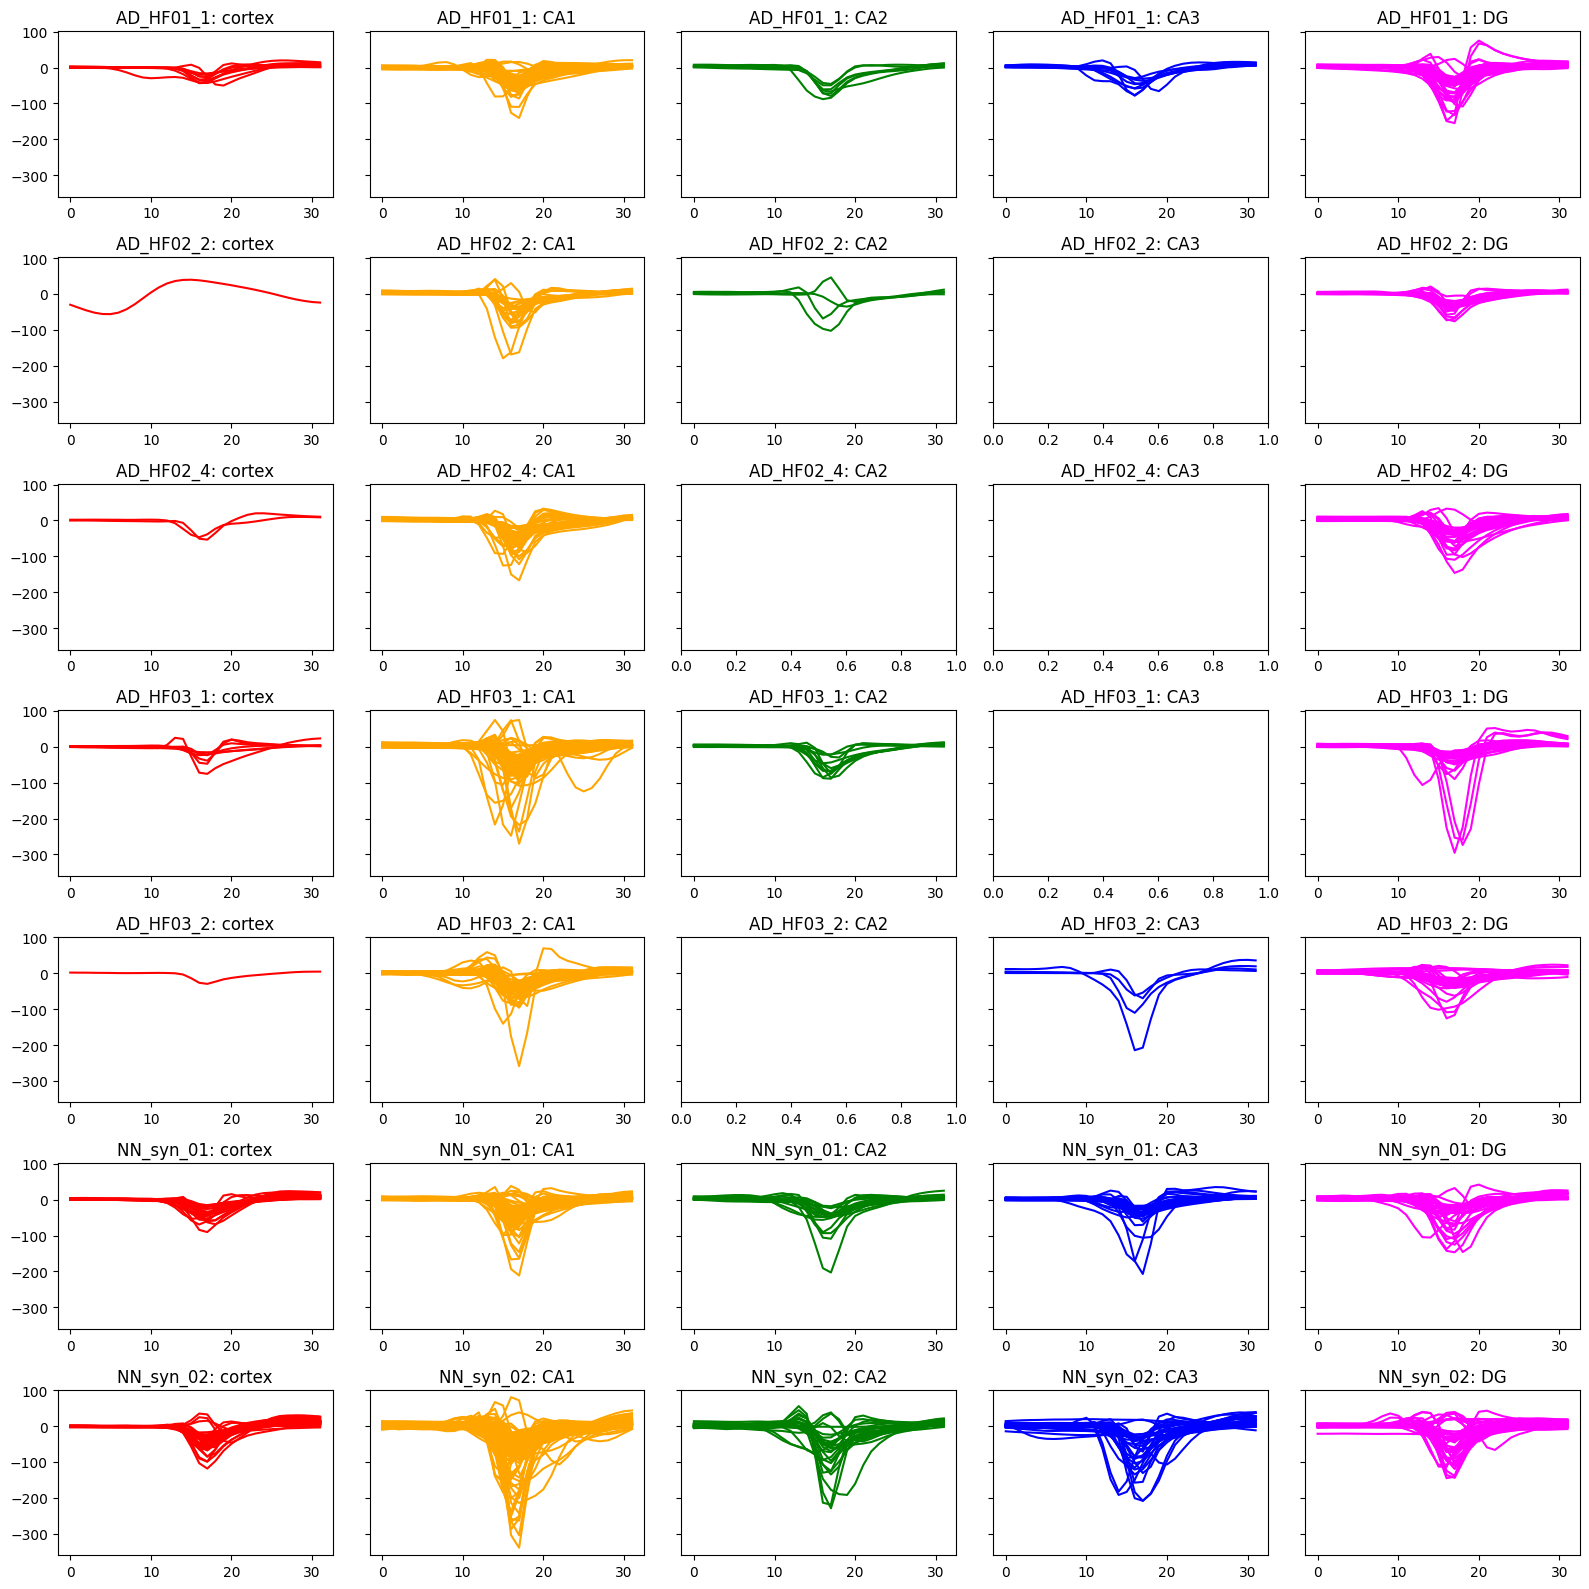

In [46]:
# normalize by the channels in std
fig, axes = plt.subplots(len(sessions), len(color_names)-1, figsize=(16, 16), sharey=True)
brain_regions = ['cortex', 'CA1', 'CA2', 'CA3', 'DG']

for s in range(len(session_names)):
    for color_idx, color in enumerate(color_names[:-1]):
        raw_waveforms = waveforms_all[s]
        colors = colors_all[s]
        
        for i, (wav, wav_color) in enumerate(zip(raw_waveforms, colors)):
            if wav_color == color:
                axes[s][color_idx].plot(wav, c=color)
    
        axes[s][color_idx].set_title(f"{session_names[s]}: {brain_regions[color_idx]}")

plt.tight_layout()
plt.show()

In [47]:
waveforms_all_concatenated = np.vstack(waveforms_all)
labels_all_concatenated = np.hstack(class_labels_all)
colors_all_concatenated = np.hstack(colors_all)

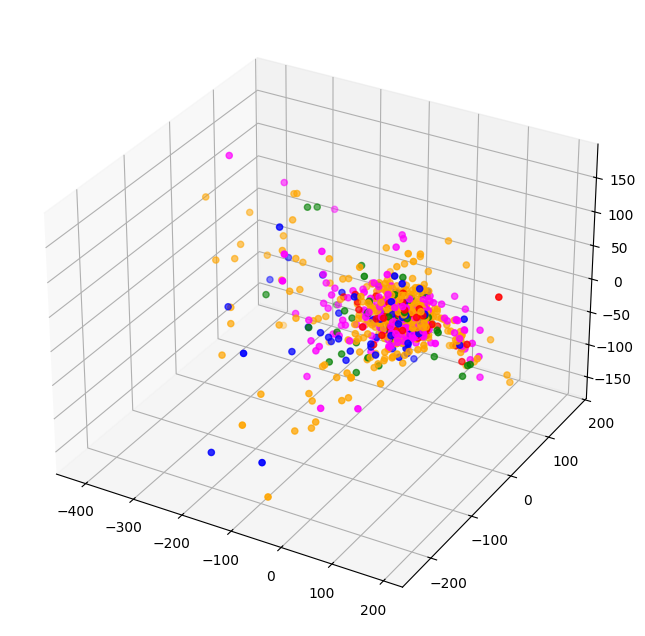

In [48]:
pca = PCA(n_components=3)
coords = pca.fit_transform(waveforms_all_concatenated)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA-transformed data
filtered_colors = colors_all_concatenated
scatter = ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=filtered_colors)
plt.show()

In [49]:
index_train, index_test = train_test_split(np.arange(len(session_names)), test_size=0.2, random_state=42)

In [50]:
X_train = np.vstack([waveforms_all[i] for i in index_train])
X_test = np.vstack([waveforms_all[i] for i in index_test])

y_train = np.hstack([class_labels_all[i] for i in index_train])
y_test = np.hstack([class_labels_all[i] for i in index_test])

In [51]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(700, 32) (185, 32) (700,) (185,)


In [ ]:
# burst index (ISI)

In [52]:
# combining multi cell activity to predict channel regions
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.6328571428571429
Test Accuracy: 0.5783783783783784


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
### try within session raw waveforms averaged over sessions
train_accs = []
test_accs = []

for i in range(len(session_names)):
    data = waveforms_all[i]
    labels = class_labels_all[i]
    
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    clf = LogisticRegression(C=1e-3)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    
    train_accs.append(accuracy_score(y_train, y_pred_train))
    test_accs.append(accuracy_score(y_test, y_pred))

print("Train Accuracy:", sum(train_accs)/len(train_accs))
print("Test Accuracy:", sum(test_accs)/len(test_accs))

Train Accuracy: 0.693160470354421
Test Accuracy: 0.5746654631321657


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

### 3. Incorperate Distance in within session

In [56]:
waveforms_all[0].shape

(134, 32)

In [57]:
len(maxWaveformCh_all[0])

134

In [58]:
waveform_length = waveforms_all[0].shape[1]
ap_cube = np.zeros((128, 8, waveform_length))
channel_to_waveform = {ch: k for k, ch in enumerate(maxWaveformCh_all[0])}

for i in range(128):
    for j in range(8):
        current_channel = i * 8 + j
        if current_channel in channel_to_waveform:
            k = channel_to_waveform[current_channel]
            ap_cube[i][j] = waveforms_all[0][k]

In [59]:
window_size = (40, 40)

pad_width = ((window_size[0] // 2, window_size[0] // 2),
             (window_size[1] // 2, window_size[1] // 2),
             (0, 0))                                    
ap_cube_padded = np.pad(ap_cube, pad_width, mode='constant', constant_values=0)

labels = class_labels_all[0]
data = []

for ch in maxWaveformCh_all[0]:
    x = ch % 128
    y = ch // 128
    
    x += window_size[0] // 2
    y += window_size[1] // 2

    window = ap_cube_padded[x - window_size[0] // 2: x + window_size[0] // 2,
                            y - window_size[1] // 2: y + window_size[1] // 2]
    data.append(window)

In [60]:
data = np.array(data)
data = data.reshape(data.shape[0], -1)

In [61]:
data.shape

(134, 51200)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

clf = LogisticRegression(C=0.01)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.8518518518518519


Text(0.5, 1.0, 'Confusion Matrix')

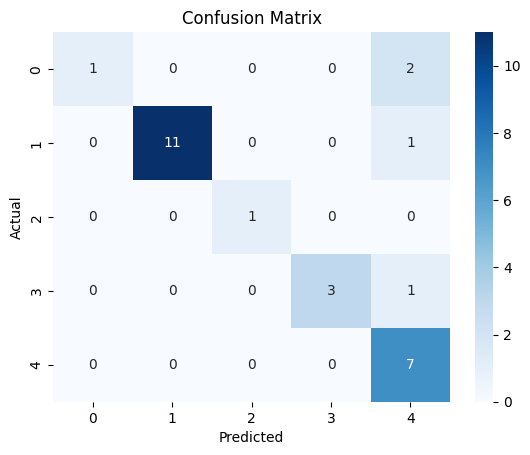

In [63]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [ ]:
sessions=['AD_HF01_Session1h', 'AD_HF02_230706_Session2', 'AD_HF02_230722_Session4', 'AD_HF03_230725_Session1', 'AD_HF03_230726_Session2', 'NN_syn_20230601', 'NN_syn_20230607']
session_names = ['AD_HF01_1', 'AD_HF02_2', 'AD_HF02_4', 'AD_HF03_1', 'AD_HF03_2', 'NN_syn_01', 'NN_syn_02']
class_labels_full = []  # class_labels of all channels (except for UNK channel)
channels_full = []

for i, session in enumerate(sessions):
    file_path = f"/scratch/th3129/shared/Neuronexus_dataset/{session}/{session}.spikes.cellinfo.mat"
    mat = loadmat_full(file_path, structname='spikes')
    raw_signal, class_labels, swr_timestamp = load_signal_labels(session_names[i])
    
    # raw_waveforms = np.vstack(mat['rawWaveform'])
    # maxWaveformCh = mat['maxWaveformCh']

    class_labels_full.append(class_labels[class_labels != 5])
    channels_full.append(np.arange(1024)[class_labels != 5])

100%|██████████| 1024/1024 [00:01<00:00, 530.96it/s]


In [50]:
def prepare_cube_data(ap_cube, maxWaveformCh, window_size = (40, 40)):
    pad_width = ((window_size[0] // 2, window_size[0] // 2),
                 (window_size[1] // 2, window_size[1] // 2),
                 (0, 0))                                    
    ap_cube_padded = np.pad(ap_cube, pad_width, mode='constant', constant_values=0)
    data = []
    
    for ch in maxWaveformCh:
        x = ch % 128
        y = ch // 128
        
        x += window_size[0] // 2
        y += window_size[1] // 2
    
        window = ap_cube_padded[x - window_size[0] // 2: x + window_size[0] // 2,
                                y - window_size[1] // 2: y + window_size[1] // 2]
        data.append(window)

    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    return data

In [75]:
### with distance (AP cube) and with selected channels (only those that are assigned max waveform)
train_accs = []
test_accs = []

for i in range(len(session_names)):
    data = prepare_cube_data(ap_cubes[i], maxWaveformCh_all[i])
    labels = class_labels_all[i]
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    clf = LogisticRegression(C=0.001)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)

    train_accs.append(accuracy_score(y_train, y_pred_train))
    test_accs.append(accuracy_score(y_test, y_pred))

print("Train Accuracy:", sum(train_accs)/len(train_accs))
print("Test Accuracy:", sum(test_accs)/len(test_accs))

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Train Accuracy: 1.0
Test Accuracy: 0.746464910750625


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
### with distance (AP cube) and with all channels
train_accs = []
test_accs = []

for i in range(len(session_names)):
    data = prepare_cube_data(ap_cubes[i], channels_full[i])
    labels = class_labels_full[i]
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
    
    clf = LogisticRegression(C=1e-5)
    clf.fit(X_train, y_train)
    
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)

    train_accs.append(accuracy_score(y_train, y_pred_train))
    test_accs.append(accuracy_score(y_test, y_pred))

print("Train Accuracy:", sum(train_accs)/len(train_accs))
print("Test Accuracy:", sum(test_accs)/len(test_accs))

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Train Accuracy: 0.9280689189183634
Test Accuracy: 0.5751472877551208


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4. Incorperate Distance in Across Session

In [72]:
waveform_length = waveforms_all[0].shape[1]
ap_cubes = np.zeros((len(session_names), 128, 8, waveform_length))

for s in range(len(session_names)):
    channel_to_waveform = {ch: k for k, ch in enumerate(maxWaveformCh_all[s])}
    
    for i in range(128):
        for j in range(8):
            current_channel = i * 8 + j
            if current_channel in channel_to_waveform:
                k = channel_to_waveform[current_channel]
                ap_cubes[s][i][j] = waveforms_all[s][k]

In [73]:
ap_cubes.shape

(7, 128, 8, 32)

In [39]:
window_size = (40, 40)

pad_width = ((window_size[0] // 2, window_size[0] // 2),
             (window_size[1] // 2, window_size[1] // 2),
             (0, 0))
ap_cubes_per_channel = []

for i, ap_cube in enumerate(ap_cubes):
    ap_cube_padded = np.pad(ap_cube, pad_width, mode='constant', constant_values=0)

    data = []
    
    for ch in maxWaveformCh_all[i]:
        x = ch % 128
        y = ch // 128
        
        x += window_size[0] // 2
        y += window_size[1] // 2
    
        window = ap_cube_padded[x - window_size[0] // 2: x + window_size[0] // 2,
                                y - window_size[1] // 2: y + window_size[1] // 2]
        data.append(window)
    ap_cubes_per_channel.append(np.array(data))

In [40]:
ap_cubes_per_channel[2].shape

(79, 40, 40, 32)

In [41]:
index_train, index_test = train_test_split(np.arange(len(session_names)), test_size=0.2, random_state=42)

In [42]:
flattened_length = window_size[0] * window_size[1] * waveform_length

X_train = np.vstack([ap_cubes_per_channel[i].reshape(-1,flattened_length) for i in index_train])
X_test = np.vstack([ap_cubes_per_channel[i].reshape(-1,flattened_length) for i in index_test])

y_train = np.hstack([class_labels_all[i] for i in index_train])
y_test = np.hstack([class_labels_all[i] for i in index_test])

In [43]:
clf = LogisticRegression(C=0.01, penalty='l1', solver='saga')
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy: 0.9114114114114115
Test Accuracy: 0.4594594594594595


/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [79]:
# using all channels in across session
train_accs = []
test_accs = []
ap_cubes_per_channel_full = []

for i in range(len(session_names)):
    data = prepare_cube_data(ap_cubes[i], channels_full[i])
    ap_cubes_per_channel_full.append(data)

In [82]:
flattened_length = window_size[0] * window_size[1] * waveform_length

X_train = np.vstack([ap_cubes_per_channel_full[i].reshape(-1,flattened_length) for i in index_train])
X_test = np.vstack([ap_cubes_per_channel_full[i].reshape(-1,flattened_length) for i in index_test])

y_train = np.hstack([class_labels_full[i] for i in index_train])
y_test = np.hstack([class_labels_full[i] for i in index_test])

In [86]:
clf = LogisticRegression(C=1e-6)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

train_accs.append(accuracy_score(y_train, y_pred_train))
test_accs.append(accuracy_score(y_test, y_pred))

print("Train Accuracy:", sum(train_accs)/len(train_accs))
print("Test Accuracy:", sum(test_accs)/len(test_accs))

/ext3/miniforge3/envs/blind_localization/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Accuracy: 0.8660487804878049
Test Accuracy: 0.4249569707401033
